# Recognizing Traffic Signs
The goal of this project is to build a model capable of determining the type of traffic sign that is displayed in an image captured under different real-life conditions and showing obstructions, poor lighting, or even the sign being far away from the camera. We provide you with labeled images already splited in three files (tran/val/test) and a predefined list of signs to recognise. 

In [7]:
# # Download and unzip
dataroot = "../dataroot/"
# !mkdir dataroot 
# !wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_1.zip
# !wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_2.zip
# !wget -P dataroot https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/data_3.zip 

In [8]:
# # Unzip
# import zipfile
# with zipfile.ZipFile(dataroot+"data_1.zip","r") as zip_ref:
#     zip_ref.extractall(dataroot)
# with zipfile.ZipFile(dataroot+"data_2.zip","r") as zip_ref:
#     zip_ref.extractall(dataroot)
# with zipfile.ZipFile(dataroot+"data_3.zip","r") as zip_ref:
#     zip_ref.extractall(dataroot)

In [9]:
# Load sign names
import pandas as pd
df = pd.read_csv("https://raw.githubusercontent.com/emmanueliarussi/DataScienceCapstone/master/3_MidtermProjects/ProjectRTS/data/signnames.csv")
signnames = pd.Series(df.SignName.values,index=df.ClassId).to_dict()
signnames

{0: 'Speed limit (20km/h)',
 1: 'Speed limit (30km/h)',
 2: 'Speed limit (50km/h)',
 3: 'Speed limit (60km/h)',
 4: 'Speed limit (70km/h)',
 5: 'Speed limit (80km/h)',
 6: 'End of speed limit (80km/h)',
 7: 'Speed limit (100km/h)',
 8: 'Speed limit (120km/h)',
 9: 'No passing',
 10: 'No passing for vehicles over 3.5 metric tons',
 11: 'Right-of-way at the next intersection',
 12: 'Priority road',
 13: 'Yield',
 14: 'Stop',
 15: 'No vehicles',
 16: 'Vehicles over 3.5 metric tons prohibited',
 17: 'No entry',
 18: 'General caution',
 19: 'Dangerous curve to the left',
 20: 'Dangerous curve to the right',
 21: 'Double curve',
 22: 'Bumpy road',
 23: 'Slippery road',
 24: 'Road narrows on the right',
 25: 'Road work',
 26: 'Traffic signals',
 27: 'Pedestrians',
 28: 'Children crossing',
 29: 'Bicycles crossing',
 30: 'Beware of ice/snow',
 31: 'Wild animals crossing',
 32: 'End of all speed and passing limits',
 33: 'Turn right ahead',
 34: 'Turn left ahead',
 35: 'Ahead only',
 36: 'Go st

In [10]:
df.to_csv("sign_names.csv")

In [11]:
# Load images
import pickle
signimages = pickle.load( open( dataroot+"train.p", "rb" ) )

The image shows a Wild animals crossing sign


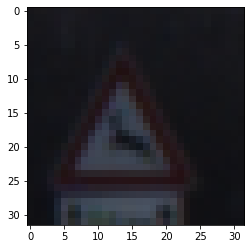

In [12]:
# Preview image
import matplotlib.pyplot as plt
import numpy as np
# import cv2

inx = 20123
plt.imshow(signimages['features'][250])
print("The image shows a {} sign".format(signnames[signimages['labels'][254]]))

In [1]:
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np
import platform
import datetime
import os
import math
import random
from toolz import pipe

%load_ext tensorboard

In [14]:
gpus= tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

In [15]:
!rd /s /q logs

In [16]:
train = signimages
with open( dataroot+"test.p", "rb" ) as fp:
    test = pickle.load(fp)
with open( dataroot+"valid.p", "rb" ) as fp:
    valid = pickle.load(fp)

### Preprocessing

In [17]:
def format_example(image):
    """
    Converts image color range to 0:1, consistent size
    """
    return tf.image.resize(tf.cast(image, tf.float32)/255, [32, 32])

In [18]:
def convert_to_tf_dataset(raw_data):
    """
    Converts raw images and labels into a tensorflow dataset
    """
    return tf.data.Dataset.from_tensor_slices(
                (
                    list(map(format_example, raw_data['features'])), 
                    tf.cast(raw_data['labels'], tf.int32)
                )
            )

#### Convert datasets to Tensorflow datasets

In [19]:
train, test, valid = tuple(map(convert_to_tf_dataset, [train, test, valid]))

In [20]:
type(train)

tensorflow.python.data.ops.dataset_ops.TensorSliceDataset

In [21]:
len(valid)

4410

##### Confirm TF conversion success by previewing image/label

In [22]:
first_image, first_label = list(train.take(1))[0]

In [23]:
signnames[first_label.numpy()]

'End of no passing'

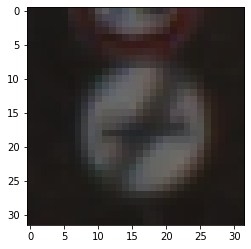

In [24]:
plt.imshow(first_image.numpy())

#### Augment Dataset

In [25]:
def random_image_flip(image: tf.Tensor) -> tf.Tensor:
    """
    Randomly flips an image left/right
    """
    return tf.image.random_flip_left_right(image)

def random_color_change(image: tf.Tensor) -> tf.Tensor:
    """
    Randomly adjusts brightness, contrast, or saturation in an image. Does not adjust
    hue
    """
    return tf.clip_by_value(
                tf.image.random_contrast(
                    tf.image.random_brightness(
                        tf.image.random_saturation(image, lower=.75, upper=1.25), 
                        .05
                    ), 
                    lower=.75,
                    upper=1
                ), 
                clip_value_min=0, 
                clip_value_max=1
            )

def random_image_rotation(image: tf.Tensor) -> tf.Tensor:
    """
    Randomly rotates and image between 30 and -30 degrees
    """
    return tfa.image.rotate(image, tf.random.uniform(shape=[], minval=-.2, maxval=.2, dtype=tf.float32))

def augment_image(image: tf.Tensor, label: tf.Tensor) -> tf.Tensor:
    """
    Performs random augmentation of image
    """
    return pipe(image,
               random_image_flip,
               random_color_change,
               random_image_rotation), label

c:\users\kitthekat\appdata\local\programs\python\python38\lib\site-packages\tensorflow_addons\image\transform_ops.py:142: UserWarning: fill_value is not supported and is always 0 for TensorFlow < 2.4.0.
  warnings.warn(


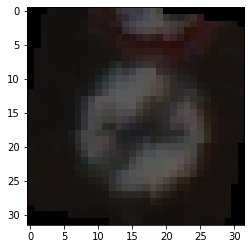

In [26]:
plt.imshow(augment_image(first_image.numpy(), 'test')[0])

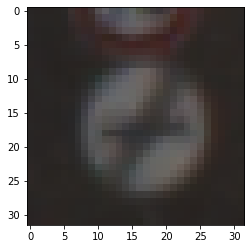

In [27]:
plt.imshow(augment_image(first_image.numpy(), 'test')[0])

In [28]:
augmented_data = train.map(augment_image)

c:\users\kitthekat\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\autograph\impl\api.py:493: UserWarning: fill_value is not supported and is always 0 for TensorFlow < 2.4.0.
  return py_builtins.overload_of(f)(*args)


In [29]:
train = train.concatenate(augmented_data)

#### Batching

In [30]:
shuffled_train = train.shuffle(len(train)).batch(32).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
shuffled_test = test.batch(32)

In [31]:
batches = tfds.as_numpy(shuffled_test)

Label batch shape: (32,) 

Image batch shape: (32, 32, 32, 3) 

Label batch: [16  1 38 33 11 38 18 12 25 35 12  7 23  7  4  9 21 20 27 38  4 33  9  3
  1 11 13 10  9 11  5 17] 

(32, 32, 3)
First batch image: [[[0.45490196 0.54509807 0.68235296]
  [0.45490196 0.5372549  0.67058825]
  [0.4627451  0.5411765  0.6745098 ]
  ...
  [0.38431373 0.44705883 0.56078434]
  [0.38039216 0.4745098  0.5764706 ]
  [0.33333334 0.4117647  0.50980395]]

 [[0.4509804  0.5568628  0.6901961 ]
  [0.4509804  0.54901963 0.68235296]
  [0.45882353 0.5529412  0.6862745 ]
  ...
  [0.46666667 0.56078434 0.6901961 ]
  [0.47058824 0.5529412  0.6784314 ]
  [0.47058824 0.54509807 0.67058825]]

 [[0.45882353 0.5529412  0.68235296]
  [0.45882353 0.5568628  0.6862745 ]
  [0.44705883 0.54901963 0.6745098 ]
  ...
  [0.47058824 0.5647059  0.7019608 ]
  [0.47843137 0.5647059  0.7019608 ]
  [0.47058824 0.56078434 0.69411767]]

 ...

 [[0.45882353 0.5372549  0.654902  ]
  [0.4509804  0.5254902  0.6431373 ]
  [0.45882353 0.52941

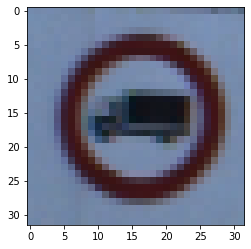

In [32]:
for batch in batches:
    image_batch, label_batch = batch
    print('Label batch shape:', label_batch.shape, '\n')
    print('Image batch shape:', image_batch.shape, '\n')
    print('Label batch:', label_batch, '\n')
    
    for batch_item_index in range(len(image_batch)):
        print(image_batch[batch_item_index].shape)
        print('First batch image:', image_batch[batch_item_index], '\n')
        plt.imshow(image_batch[batch_item_index])
        plt.show()
        # Break to shorten the output.
        break
    # Break to shorten the output.
    break

### Training

#### Create Model

In [33]:
model = tf.keras.models.Sequential()

model.add(
    tf.keras.layers.Convolution2D(
        input_shape=(32, 32, 3),
        filters=64,
        kernel_size=3,
        activation='relu'
    )
)

model.add(
    tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=(2, 2),
        padding='same'
    )
)

model.add(
    tf.keras.layers.Convolution2D(
        filters=64, 
        kernel_size=3, 
        activation='relu'
    )
)

model.add(
    tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=(2, 2),
        padding='same'
    )
)

model.add(
    tf.keras.layers.Convolution2D(
        filters=128, 
        kernel_size=3, 
        activation='relu'
    )
)

model.add(
    tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=(2, 2),
        padding='same'
    )
)

model.add(
    tf.keras.layers.Convolution2D(
        filters=128, 
        kernel_size=3, 
        activation='relu'
    )
)

model.add(
    tf.keras.layers.MaxPooling2D(
        pool_size=(2, 2),
        strides=(2, 2),
        padding='same'
    )
)

model.add(
    tf.keras.layers.Flatten()
)

model.add(
    tf.keras.layers.Dropout(0.5)
)

model.add(
    tf.keras.layers.Dense(
        units=256, 
        activation='relu'
    )
)

model.add(
    tf.keras.layers.Dense(
        units=512, 
        activation='relu'
    )
)

model.add(
    tf.keras.layers.Dense(
        units=256, 
        activation='relu'
    )
)

model.add(
    tf.keras.layers.Dense(
        units=len(signnames.keys()), 
        activation='softmax'
    )
)

##### Model Summary

In [34]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 128)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 128)         1

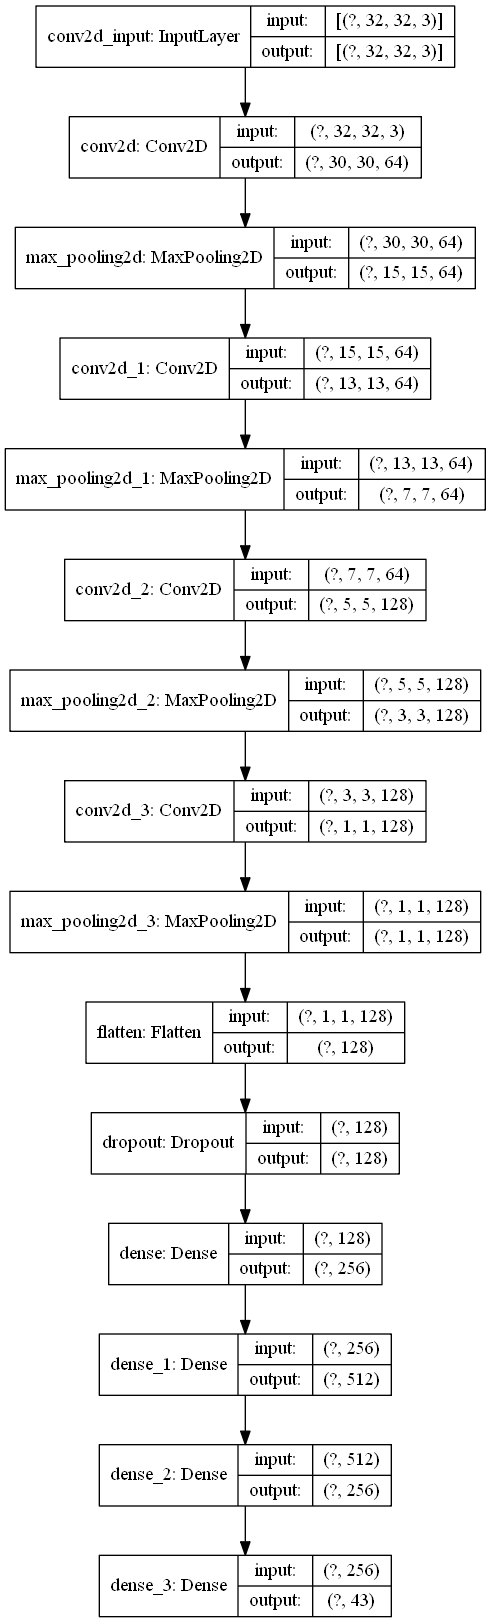

In [35]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
)

#### Compile Model

In [36]:
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.sparse_categorical_crossentropy,
    metrics=['accuracy']
)

#### Prepare callbacks/tensorboard

In [37]:
steps_per_epoch = len(shuffled_train) // 32
validation_steps = len(shuffled_test) // 32

In [38]:
!rd /s /q "tmp/checkpoints"
!rd /s /q "logs"

The system cannot find the file specified.


In [39]:
# Preparing callbacks.
os.makedirs('logs/fit', exist_ok=True)
tensorboard_log_dir = 'logs/fit/' + datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=tensorboard_log_dir,
    histogram_freq=1
)

os.makedirs('tmp/checkpoints', exist_ok=True)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='tmp/checkpoints/weights.{epoch:02d}-{val_loss:.2f}.hdf5'
)

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    patience=30,
    monitor='val_accuracy'
)

In [40]:
training_history = model.fit(
    x=shuffled_train.repeat(),
    validation_data=shuffled_test.repeat(),
    epochs=750,
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    callbacks=[
        model_checkpoint_callback,
#         early_stopping_callback,
        tensorboard_callback
    ],
    verbose=1
)

Epoch 1/750
 1/67 [..............................] - ETA: 0s - loss: 3.7648 - accuracy: 0.0312WARNING:tensorflow:From c:\users\kitthekat\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
67/67 [==============================] - 1s 11ms/step - loss: 3.5689 - accuracy: 0.0583 - val_loss: 3.5736 - val_accuracy: 0.0547
Epoch 2/750
67/67 [==============================] - 0s 6ms/step - loss: 3.4826 - accuracy: 0.0611 - val_loss: 3.4108 - val_accuracy: 0.0885
Epoch 3/750
67/67 [==============================] - 0s 6ms/step - loss: 3.2609 - accuracy: 0.0951 - val_loss: 3.1536 - val_accuracy: 0.0729
Epoch 4/750
67/67 [==============================] - 0s 6ms/step - loss: 2.9337 - accuracy: 0.1600 - val_loss: 2.6387 - val_accuracy: 0.2083
Epoch 5/750
67/67 [===================

In [ ]:
# from ..send_text import send_text
# send_text()

In [3]:
%tensorboard --logdir logs/fit --port 4241

Reusing TensorBoard on port 4241 (pid 22316), started 0:33:45 ago. (Use '!kill 22316' to kill it.)

In [ ]:
# !taskkill /F /PID 20296

In [41]:
model.save('exp4.mdl')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: exp4.mdl\assets


In [ ]:
from tensorflow import keras
model = keras.models.load_model('exp4.mdl')

In [45]:
model.load_weights("tmp/checkpoints/weights.597-0.21.hdf5")

### Check accuracy on validation dataset

In [46]:
valid_t = tfds.as_numpy(valid)

In [47]:
valid_t = list(map(lambda x: (x[0].reshape(-1, 32, 32, 3), x[1]), valid_t))

In [48]:
valid_t = list(zip(*valid_t))

In [49]:
preds = list(map(lambda x: np.argmax(model.predict(x), axis=-1), valid_t[0]))

In [50]:
from sklearn.metrics import accuracy_score

In [51]:
accuracy_score(valid_t[1], preds)

0.9444444444444444